# TP FloatPairs - Recherche Locale

## 1. Imports

In [16]:
# Installation si nécessaire : !pip install jmetalpy numpy pandas matplotlib

from jmetal.algorithm.singleobjective.local_search import LocalSearch
from jmetal.operator.mutation import PolynomialMutation
from jmetal.core.problem import Problem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

%matplotlib inline
print("✓ Imports OK")

✓ Imports OK


## 2. Définition du Problème FloatPairs

In [17]:
class FloatPairsMax(Problem):
    """
    Problème FloatPairs: Maximiser le nombre de paires adjacentes de signes différents
    dans une séquence de nombres flottants.
    
    Pour une séquence de n nombres, le maximum théorique est n-1 paires
    (obtenu par alternance parfaite des signes).
    """
    def __init__(self, number_of_floats: int, min_value: float, max_value: float):
        super().__init__()
        self.number_of_floats = number_of_floats
        self.min_value = min_value
        self.max_value = max_value
        
        self.lower_bound = [self.min_value] * number_of_floats
        self.upper_bound = [self.max_value] * number_of_floats
        
        self.number_of_objectives = 1
        # IMPORTANT: On MINIMISE l'objectif pour être compatible avec JMetalPy
        # On va donc retourner -(nombre de paires)
        self.obj_directions = [self.MINIMIZE]
        self.obj_labels = ['NegativePairsCount']
        
    def number_of_variables(self) -> int:
        return self.number_of_floats
    
    def number_of_objectives(self) -> int:
        return 1
    
    def number_of_constraints(self) -> int:
        return 0
    
    def evaluate(self, solution: FloatSolution) -> FloatSolution:
        """
        Calcule le nombre de paires adjacentes de signes différents.
        Retourne la valeur NÉGATIVE pour minimisation.
        """
        variables = solution.variables
        pairs_count = 0
        
        # Parcours des paires adjacentes
        for i in range(len(variables) - 1):
            # Vérification si les signes sont différents
            if (variables[i] * variables[i + 1] < 0) or \
               (variables[i] == 0 and variables[i + 1] < 0) or \
               (variables[i + 1] == 0 and variables[i] < 0):
                pairs_count += 1
        
        # On retourne la valeur NÉGATIVE pour minimisation
        solution.objectives[0] = -pairs_count
        return solution
    
    def create_solution(self) -> FloatSolution:
        """
        Crée une solution aléatoire
        """
        new_solution = FloatSolution(
            self.lower_bound,
            self.upper_bound,
            self.number_of_objectives,
            self.number_of_constraints()
        )
        
        # Génération de nombres aléatoires dans l'intervalle
        new_solution.variables = [
            random.uniform(self.lower_bound[i], self.upper_bound[i])
            for i in range(self.number_of_variables())
        ]
        
        return new_solution
    
    def name(self) -> str:
        return 'FloatPairsMax'

print("✓ Classe FloatPairsMax définie")

✓ Classe FloatPairsMax définie


## 3. Test du Problème

In [18]:
# Test rapide du problème
print("=== Test du problème FloatPairs ===")

n = 8
bi = -10.00
bs = 10.00

problem = FloatPairsMax(number_of_floats=n, min_value=bi, max_value=bs)

# Test avec solution optimale théorique (alternance)
optimal_solution = problem.create_solution()
optimal_solution.variables = [bs if i % 2 == 0 else bi for i in range(n)]
optimal_solution = problem.evaluate(optimal_solution)

print(f"Solution optimale: {[f'{v:.2f}' for v in optimal_solution.variables]}")
print(f"Fitness (négatif): {optimal_solution.objectives[0]}")
print(f"Nombre de paires réel: {-optimal_solution.objectives[0]}")
print(f"Maximum théorique: {n-1} paires\n")

# Test avec solution aléatoire
random_solution = problem.create_solution()
random_solution = problem.evaluate(random_solution)
print(f"Solution aléatoire: {[f'{v:.2f}' for v in random_solution.variables]}")
print(f"Nombre de paires: {-random_solution.objectives[0]}")

=== Test du problème FloatPairs ===
Solution optimale: ['10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00', '10.00', '-10.00']
Fitness (négatif): -7
Nombre de paires réel: 7
Maximum théorique: 7 paires

Solution aléatoire: ['-0.95', '-3.60', '0.99', '7.29', '-0.38', '6.62', '9.96', '-2.92']
Nombre de paires: 4


## 4. Protocole Expérimental

### 4.1 Paramètres Communs

In [19]:
# Paramètres du problème
N_FLOATS = 200
MIN_VALUE = -10.0
MAX_VALUE = 10.0
OPTIMAL_VALUE = -(N_FLOATS - 1)  # -7 pour minimisation (7 paires pour maximisation)

# Paramètres expérimentaux
MAX_EVALUATIONS = 5000
N_RUNS = 20

# Paramètre de mutation par défaut
MUTATION_DISTRIBUTION_INDEX = 20.0

# Tableau 1 : Paramètres communs
common_params = pd.DataFrame({
    'Paramètre': [
        'Nombre de floats (n)',
        'Intervalle des valeurs',
        'Optimal théorique',
        'Nombre d\'évaluations',
        'Nombre de runs',
        'Mutation distribution index'
    ],
    'Valeur': [
        N_FLOATS,
        f'[{MIN_VALUE}, {MAX_VALUE}]',
        f'{-OPTIMAL_VALUE} paires',
        MAX_EVALUATIONS,
        N_RUNS,
        MUTATION_DISTRIBUTION_INDEX
    ]
})

print("Tableau 1 : Paramètres communs")
print("="*60)
display(common_params)

Tableau 1 : Paramètres communs


,Paramètre,Valeur
0,Nombre de floats (n),200
1,Intervalle des valeurs,"[-10.0, 10.0]"
2,Optimal théorique,199 paires
3,Nombre d'évaluations,5000
4,Nombre de runs,20
5,Mutation distribution index,20.0


### 4.2 Configurations de Recherche Locale Testées

Nous allons tester **5 configurations différentes** de probabilité de mutation :
- **LS1** : `mutation_probability = None` (utilise 1/n par défaut = 0.125)
- **LS2** : `mutation_probability = 0.25` (faible mutation)
- **LS3** : `mutation_probability = 0.5` (mutation modérée)
- **LS4** : `mutation_probability = 0.75` (forte mutation)
- **LS5** : `mutation_probability = 1.0` (mutation maximale)

In [20]:
# Tableau 2 : Configurations testées
configurations = {
    'LS1': {
        'nom': 'Mutation par défaut (1/n)',
        'mutation_probability': None,  # Utilise 1/n par défaut
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS2': {
        'nom': 'Mutation faible (0.25)',
        'mutation_probability': 0.25,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS3': {
        'nom': 'Mutation modérée (0.5)',
        'mutation_probability': 0.5,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS4': {
        'nom': 'Mutation forte (0.75)',
        'mutation_probability': 0.75,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    },
    'LS5': {
        'nom': 'Mutation maximale (1.0)',
        'mutation_probability': 1.0,
        'mutation_distribution_index': MUTATION_DISTRIBUTION_INDEX
    }
}

# Création du tableau de configurations
config_data = []
for key, config in configurations.items():
    # Calcul de la probabilité effective
    prob_display = config['mutation_probability'] if config['mutation_probability'] is not None else 1.0 / N_FLOATS
    
    config_data.append({
        'Config': key,
        'Description': config['nom'],
        'Mutation Probability': f"{prob_display:.4f}",
        'Mutation Index': config['mutation_distribution_index']
    })

config_df = pd.DataFrame(config_data)

print("Tableau 2 : Configurations de Recherche Locale")
print("="*60)
display(config_df)

Tableau 2 : Configurations de Recherche Locale


,Config,Description,Mutation Probability,Mutation Index
0,LS1,Mutation par défaut (1/n),0.0050,20.0
1,LS2,Mutation faible (0.25),0.2500,20.0
2,LS3,Mutation modérée (0.5),0.5000,20.0
3,LS4,Mutation forte (0.75),0.7500,20.0
4,LS5,Mutation maximale (1.0),1.0000,20.0


## 5. Fonction d'Exécution d'un Run

In [21]:
def run_local_search(problem, config, max_evaluations, verbose=False):
    """
    Exécute un run de recherche locale avec une configuration donnée.
    
    Args:
        problem: Instance du problème FloatPairsMax
        config: Dictionnaire de configuration
        max_evaluations: Nombre maximum d'évaluations
        verbose: Afficher les logs détaillés
    
    Returns:
        tuple: (fitness, temps_execution)
    """
    # Configuration de l'opérateur de mutation
    # Si mutation_probability est None, on utilise 1/n
    mutation_prob = config['mutation_probability']
    if mutation_prob is None:
        mutation_prob = 1.0 / problem.number_of_variables()
    
    mutation = PolynomialMutation(
        probability=mutation_prob,
        distribution_index=config['mutation_distribution_index']
    )
    
    # Création de l'algorithme de recherche locale
    algorithm = LocalSearch(
        problem=problem,
        mutation=mutation,
        termination_criterion=StoppingByEvaluations(max_evaluations=max_evaluations)
    )
    
    # Exécution
    start_time = time.time()
    algorithm.run()
    execution_time = time.time() - start_time
    
    # Récupération du résultat
    result = algorithm.result()
    fitness = result.objectives[0]  # Valeur négative (minimisation)
    
    if verbose:
        print(f"  Fitness: {fitness} ({-fitness} paires)")
        print(f"  Temps: {execution_time:.4f}s")
    
    return fitness, execution_time

print("✓ Fonction run_local_search définie")

✓ Fonction run_local_search définie


## 6. Exécution des Expérimentations

### 6.1 Runs pour Chaque Configuration

Nous allons effectuer **20 runs** pour chaque configuration de recherche locale.

In [22]:
# Création du problème
problem = FloatPairsMax(number_of_floats=N_FLOATS, min_value=MIN_VALUE, max_value=MAX_VALUE)

# Dictionnaire pour stocker tous les résultats
results = {}

# Exécution des runs pour chaque configuration
for config_name, config in configurations.items():
    print(f"\n{'='*80}")
    print(f"Configuration: {config_name} - {config['nom']}")
    print(f"{'='*80}")
    
    fitness_values = []
    execution_times = []
    
    for run in range(1, N_RUNS + 1):
        print(f"\nRun {run}/{N_RUNS}", end=" ")
        
        fitness, exec_time = run_local_search(
            problem=problem,
            config=config,
            max_evaluations=MAX_EVALUATIONS,
            verbose=False
        )
        
        fitness_values.append(fitness)
        execution_times.append(exec_time)
        
        # Affichage simplifié
        print(f"→ Fitness: {fitness:.2f} ({-fitness:.0f} paires) | Temps: {exec_time:.4f}s")
    
    # Stockage des résultats
    results[config_name] = {
        'fitness_values': fitness_values,
        'execution_times': execution_times
    }
    
    # Statistiques de la configuration
    print(f"\n{'─'*80}")
    print(f"Statistiques pour {config_name}:")
    print(f"  Fitness moyen: {np.mean(fitness_values):.2f} paires")
    print(f"  Médiane: {np.median(fitness_values):.2f}")
    print(f"  Écart-type: {np.std(fitness_values):.4f}")
    print(f"  Min: {np.min(fitness_values):.2f} | Max: {np.max(fitness_values):.2f}")
    print(f"  Temps moyen: {np.mean(execution_times):.4f}s")
    print(f"{'─'*80}")

print(f"\n{'='*80}")
print("✓ Toutes les expérimentations sont terminées !")
print(f"{'='*80}")


Configuration: LS1 - Mutation par défaut (1/n)

Run 1/20 

[2026-02-02 10:44:01,493] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:01,496] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:01,498] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:01,500] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2026-02-02 10:44:02,677] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:02,678] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:02,679] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:02,679] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:02,680] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -124.00 (124 paires) | Temps: 1.1847s

Run 2/20 

[2026-02-02 10:44:03,610] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:03,610] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:03,611] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:03,611] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:03,612] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -123.00 (123 paires) | Temps: 0.9323s

Run 3/20 

[2026-02-02 10:44:04,527] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:04,527] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:04,528] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:04,529] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:04,529] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -129.00 (129 paires) | Temps: 0.9169s

Run 4/20 

[2026-02-02 10:44:05,464] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:05,465] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:05,465] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:05,466] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:05,466] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -118.00 (118 paires) | Temps: 0.9373s

Run 5/20 

[2026-02-02 10:44:06,406] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:06,407] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:06,407] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:06,408] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:06,409] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -122.00 (122 paires) | Temps: 0.9418s

Run 6/20 

[2026-02-02 10:44:07,350] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:07,350] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:07,351] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:07,351] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:07,352] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -128.00 (128 paires) | Temps: 0.9437s

Run 7/20 

[2026-02-02 10:44:08,289] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:08,290] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:08,290] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:08,291] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:08,291] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -126.00 (126 paires) | Temps: 0.9391s

Run 8/20 

[2026-02-02 10:44:09,210] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:09,211] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:09,211] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:09,212] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:09,213] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -118.00 (118 paires) | Temps: 0.9212s

Run 9/20 

[2026-02-02 10:44:10,129] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:10,130] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:10,130] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:10,131] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:10,132] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -131.00 (131 paires) | Temps: 0.9188s

Run 10/20 

[2026-02-02 10:44:11,047] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:11,048] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:11,048] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:11,049] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:11,049] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -145.00 (145 paires) | Temps: 0.9179s

Run 11/20 

[2026-02-02 10:44:12,004] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:12,005] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:12,005] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:12,006] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:12,006] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -131.00 (131 paires) | Temps: 0.9570s

Run 12/20 

[2026-02-02 10:44:12,925] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:12,926] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:12,927] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:12,928] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:12,928] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -139.00 (139 paires) | Temps: 0.9206s

Run 13/20 

[2026-02-02 10:44:13,825] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:13,825] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:13,826] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:13,826] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:13,827] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -139.00 (139 paires) | Temps: 0.8995s

Run 14/20 

[2026-02-02 10:44:14,726] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:14,727] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:14,728] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:14,728] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:14,729] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -125.00 (125 paires) | Temps: 0.9018s

Run 15/20 

[2026-02-02 10:44:15,688] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:15,689] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:15,689] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:15,690] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:15,690] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -128.00 (128 paires) | Temps: 0.9614s

Run 16/20 

[2026-02-02 10:44:16,599] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:16,600] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:16,600] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:16,601] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:16,601] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -118.00 (118 paires) | Temps: 0.9111s

Run 17/20 

[2026-02-02 10:44:17,530] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:17,531] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:17,532] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:17,533] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:17,533] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -146.00 (146 paires) | Temps: 0.9312s

Run 18/20 

[2026-02-02 10:44:18,450] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:18,450] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:18,451] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:18,451] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:18,452] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -135.00 (135 paires) | Temps: 0.9190s

Run 19/20 

[2026-02-02 10:44:19,358] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:19,358] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:19,359] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:19,359] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:19,360] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -130.00 (130 paires) | Temps: 0.9080s

Run 20/20 

[2026-02-02 10:44:20,257] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:20,259] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:20,260] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:20,260] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:20,261] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -132.00 (132 paires) | Temps: 0.8997s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS1:
  Fitness moyen: -129.35 paires
  Médiane: -128.50
  Écart-type: 8.0516
  Min: -146.00 | Max: -118.00
  Temps moyen: 0.9382s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS2 - Mutation faible (0.25)

Run 1/20 

[2026-02-02 10:44:21,280] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:21,281] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:21,281] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:21,282] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:21,283] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -171.00 (171 paires) | Temps: 1.0221s

Run 2/20 

[2026-02-02 10:44:22,327] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:22,327] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:22,328] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:22,329] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:22,329] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -171.00 (171 paires) | Temps: 1.0463s

Run 3/20 

[2026-02-02 10:44:23,370] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:23,371] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:23,371] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:23,372] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:23,372] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -171.00 (171 paires) | Temps: 1.0430s

Run 4/20 

[2026-02-02 10:44:24,413] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:24,414] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:24,414] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:24,415] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:24,415] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -176.00 (176 paires) | Temps: 1.0433s

Run 5/20 

[2026-02-02 10:44:25,533] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:25,534] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:25,534] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:25,535] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:25,535] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -176.00 (176 paires) | Temps: 1.1196s

Run 6/20 

[2026-02-02 10:44:26,558] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:26,558] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:26,559] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:26,559] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:26,560] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -172.00 (172 paires) | Temps: 1.0248s

Run 7/20 

[2026-02-02 10:44:27,630] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:27,631] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:27,631] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:27,632] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:27,632] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -175.00 (175 paires) | Temps: 1.0724s

Run 8/20 

[2026-02-02 10:44:28,657] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:28,658] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:28,658] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:28,659] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:28,660] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -179.00 (179 paires) | Temps: 1.0269s

Run 9/20 

[2026-02-02 10:44:29,785] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:29,786] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:29,787] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:29,788] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:29,788] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -169.00 (169 paires) | Temps: 1.1282s

Run 10/20 

[2026-02-02 10:44:30,814] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:30,815] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:30,815] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:30,816] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:30,816] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -171.00 (171 paires) | Temps: 1.0282s

Run 11/20 

[2026-02-02 10:44:31,844] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:31,844] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:31,845] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:31,846] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:31,846] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -175.00 (175 paires) | Temps: 1.0298s

Run 12/20 

[2026-02-02 10:44:32,912] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:32,913] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:32,913] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:32,914] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:32,915] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -172.00 (172 paires) | Temps: 1.0683s

Run 13/20 

[2026-02-02 10:44:33,942] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:33,943] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:33,943] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:33,944] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:33,944] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -170.00 (170 paires) | Temps: 1.0298s

Run 14/20 

[2026-02-02 10:44:34,971] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:34,972] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:34,972] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:34,973] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:34,973] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -177.00 (177 paires) | Temps: 1.0289s

Run 15/20 

[2026-02-02 10:44:36,044] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:36,045] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:36,045] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:36,047] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:36,048] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -169.00 (169 paires) | Temps: 1.0730s

Run 16/20 

[2026-02-02 10:44:37,078] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:37,079] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:37,080] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:37,080] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:37,081] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -175.00 (175 paires) | Temps: 1.0343s

Run 17/20 

[2026-02-02 10:44:38,152] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:38,153] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:38,154] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:38,154] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:38,155] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -173.00 (173 paires) | Temps: 1.0735s

Run 18/20 

[2026-02-02 10:44:39,178] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:39,179] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:39,180] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:39,181] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:39,182] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -171.00 (171 paires) | Temps: 1.0258s

Run 19/20 

[2026-02-02 10:44:40,228] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:40,229] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:40,230] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:40,231] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:40,231] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -174.00 (174 paires) | Temps: 1.0499s

Run 20/20 

[2026-02-02 10:44:41,260] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:41,261] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:41,262] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:41,263] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:41,264] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -179.00 (179 paires) | Temps: 1.0318s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS2:
  Fitness moyen: -173.30 paires
  Médiane: -172.50
  Écart-type: 3.0017
  Min: -179.00 | Max: -169.00
  Temps moyen: 1.0500s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS3 - Mutation modérée (0.5)

Run 1/20 

[2026-02-02 10:44:42,434] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:42,435] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:42,436] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:42,437] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:42,438] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -173.00 (173 paires) | Temps: 1.1736s

Run 2/20 

[2026-02-02 10:44:43,640] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:43,640] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:43,641] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:43,641] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:43,642] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -171.00 (171 paires) | Temps: 1.2055s

Run 3/20 

[2026-02-02 10:44:44,789] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:44,789] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:44,790] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:44,790] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:44,791] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -170.00 (170 paires) | Temps: 1.1490s

Run 4/20 

[2026-02-02 10:44:46,040] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:46,041] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:46,041] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:46,042] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:46,042] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -162.00 (162 paires) | Temps: 1.2510s

Run 5/20 

[2026-02-02 10:44:47,208] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:47,208] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:47,209] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:47,209] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:47,210] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -163.00 (163 paires) | Temps: 1.1678s

Run 6/20 

[2026-02-02 10:44:48,396] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:48,397] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:48,398] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:48,398] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:48,399] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -168.00 (168 paires) | Temps: 1.1882s

Run 7/20 

[2026-02-02 10:44:49,559] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:49,560] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:49,560] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:49,561] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:49,562] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -166.00 (166 paires) | Temps: 1.1630s

Run 8/20 

[2026-02-02 10:44:50,742] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:50,742] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:50,743] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:50,743] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:50,744] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -172.00 (172 paires) | Temps: 1.1822s

Run 9/20 

[2026-02-02 10:44:51,905] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:51,906] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:51,907] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:51,907] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:51,908] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -169.00 (169 paires) | Temps: 1.1637s

Run 10/20 

[2026-02-02 10:44:53,101] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:53,102] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:53,102] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:53,104] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:53,104] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -171.00 (171 paires) | Temps: 1.1957s

Run 11/20 

[2026-02-02 10:44:54,273] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:54,273] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:54,274] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:54,274] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:54,275] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -169.00 (169 paires) | Temps: 1.1712s

Run 12/20 

[2026-02-02 10:44:55,458] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:55,458] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:55,459] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:55,460] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:55,460] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -166.00 (166 paires) | Temps: 1.1852s

Run 13/20 

[2026-02-02 10:44:56,634] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:56,634] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:56,635] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:56,636] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:56,636] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -165.00 (165 paires) | Temps: 1.1757s

Run 14/20 

[2026-02-02 10:44:57,839] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:57,840] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:57,840] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:57,841] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:57,841] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -166.00 (166 paires) | Temps: 1.2055s

Run 15/20 

[2026-02-02 10:44:59,000] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:44:59,000] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:44:59,001] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:44:59,001] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:44:59,002] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -166.00 (166 paires) | Temps: 1.1603s

Run 16/20 

[2026-02-02 10:45:00,275] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:00,275] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:00,276] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:00,277] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:00,277] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -167.00 (167 paires) | Temps: 1.2750s

Run 17/20 

[2026-02-02 10:45:01,718] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:01,719] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:01,719] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:01,720] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:01,721] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -164.00 (164 paires) | Temps: 1.4430s

Run 18/20 

[2026-02-02 10:45:03,393] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:03,394] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:03,394] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:03,395] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:03,396] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -164.00 (164 paires) | Temps: 1.6750s

Run 19/20 

[2026-02-02 10:45:04,641] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:04,642] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:04,642] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:04,643] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:04,643] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -169.00 (169 paires) | Temps: 1.2482s

Run 20/20 

[2026-02-02 10:45:06,089] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:06,091] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:06,092] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:06,092] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:06,093] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -171.00 (171 paires) | Temps: 1.4481s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS3:
  Fitness moyen: -167.60 paires
  Médiane: -167.50
  Écart-type: 3.0887
  Min: -173.00 | Max: -162.00
  Temps moyen: 1.2413s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS4 - Mutation forte (0.75)

Run 1/20 

[2026-02-02 10:45:07,478] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:07,479] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:07,479] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:07,480] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:07,481] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -155.00 (155 paires) | Temps: 1.3880s

Run 2/20 

[2026-02-02 10:45:08,803] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:08,804] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:08,804] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:08,804] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:08,805] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -163.00 (163 paires) | Temps: 1.3248s

Run 3/20 

[2026-02-02 10:45:10,065] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:10,065] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:10,066] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:10,067] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:10,067] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -160.00 (160 paires) | Temps: 1.2618s

Run 4/20 

[2026-02-02 10:45:11,375] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:11,375] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:11,376] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:11,376] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:11,377] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -159.00 (159 paires) | Temps: 1.3097s

Run 5/20 

[2026-02-02 10:45:12,669] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:12,670] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:12,671] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:12,671] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:12,672] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -161.00 (161 paires) | Temps: 1.2948s

Run 6/20 

[2026-02-02 10:45:13,949] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:13,950] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:13,950] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:13,951] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:13,952] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -153.00 (153 paires) | Temps: 1.2795s

Run 7/20 

[2026-02-02 10:45:15,221] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:15,222] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:15,222] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:15,223] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:15,223] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -170.00 (170 paires) | Temps: 1.2719s

Run 8/20 

[2026-02-02 10:45:16,539] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:16,540] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:16,540] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:16,541] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:16,541] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -149.00 (149 paires) | Temps: 1.3178s

Run 9/20 

[2026-02-02 10:45:17,815] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:17,816] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:17,816] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:17,817] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:17,818] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -155.00 (155 paires) | Temps: 1.2763s

Run 10/20 

[2026-02-02 10:45:19,335] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:19,336] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:19,337] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:19,337] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:19,337] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -159.00 (159 paires) | Temps: 1.5201s

Run 11/20 

[2026-02-02 10:45:20,905] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:20,906] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:20,907] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:20,907] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:20,908] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -159.00 (159 paires) | Temps: 1.5698s

Run 12/20 

[2026-02-02 10:45:22,566] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:22,567] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:22,567] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:22,568] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:22,569] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -157.00 (157 paires) | Temps: 1.6606s

Run 13/20 

[2026-02-02 10:45:23,997] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:23,998] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:23,998] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:23,999] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:24,000] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -156.00 (156 paires) | Temps: 1.4310s

Run 14/20 

[2026-02-02 10:45:25,523] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:25,524] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:25,524] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:25,525] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:25,525] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -150.00 (150 paires) | Temps: 1.5259s

Run 15/20 

[2026-02-02 10:45:26,939] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:26,940] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:26,941] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:26,941] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:26,942] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -160.00 (160 paires) | Temps: 1.4162s

Run 16/20 

[2026-02-02 10:45:28,470] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:28,470] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:28,471] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:28,472] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:28,472] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -152.00 (152 paires) | Temps: 1.5303s

Run 17/20 

[2026-02-02 10:45:30,318] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:30,318] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:30,319] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:30,320] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:30,321] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -149.00 (149 paires) | Temps: 1.8478s

Run 18/20 

[2026-02-02 10:45:31,767] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:31,767] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:31,768] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:31,768] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:31,769] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -158.00 (158 paires) | Temps: 1.4488s

Run 19/20 

[2026-02-02 10:45:33,332] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:33,333] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:33,333] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:33,334] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:33,335] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -156.00 (156 paires) | Temps: 1.5653s

Run 20/20 

[2026-02-02 10:45:35,338] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:35,339] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:35,339] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:35,340] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:35,340] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -161.00 (161 paires) | Temps: 2.0055s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS4:
  Fitness moyen: -157.10 paires
  Médiane: -157.50
  Écart-type: 4.9790
  Min: -170.00 | Max: -149.00
  Temps moyen: 1.4623s
────────────────────────────────────────────────────────────────────────────────

Configuration: LS5 - Mutation maximale (1.0)

Run 1/20 

[2026-02-02 10:45:37,056] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:37,057] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:37,057] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:37,058] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:37,059] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -140.00 (140 paires) | Temps: 1.7176s

Run 2/20 

[2026-02-02 10:45:38,753] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:38,754] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:38,755] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:38,755] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:38,756] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -158.00 (158 paires) | Temps: 1.6970s

Run 3/20 

[2026-02-02 10:45:40,203] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:40,204] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:40,205] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:40,207] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:40,208] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -147.00 (147 paires) | Temps: 1.4505s

Run 4/20 

[2026-02-02 10:45:42,104] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:42,104] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:42,105] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:42,105] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:42,106] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -148.00 (148 paires) | Temps: 1.8997s

Run 5/20 

[2026-02-02 10:45:43,522] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:43,522] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:43,523] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:43,524] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:43,524] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -148.00 (148 paires) | Temps: 1.4180s

Run 6/20 

[2026-02-02 10:45:44,903] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:44,903] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:44,904] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:44,904] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:44,905] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -162.00 (162 paires) | Temps: 1.3809s

Run 7/20 

[2026-02-02 10:45:46,329] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:46,330] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:46,331] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:46,331] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:46,332] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -142.00 (142 paires) | Temps: 1.4267s

Run 8/20 

[2026-02-02 10:45:47,717] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:47,718] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:47,718] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:47,719] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:47,719] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -154.00 (154 paires) | Temps: 1.3879s

Run 9/20 

[2026-02-02 10:45:49,126] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:49,126] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:49,128] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:49,129] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:49,129] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -152.00 (152 paires) | Temps: 1.4082s

Run 10/20 

[2026-02-02 10:45:50,551] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:50,552] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:50,552] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:50,553] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:50,553] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -148.00 (148 paires) | Temps: 1.4253s

Run 11/20 

[2026-02-02 10:45:51,967] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:51,968] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:51,968] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:51,969] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:51,969] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -156.00 (156 paires) | Temps: 1.4158s

Run 12/20 

[2026-02-02 10:45:53,357] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:53,358] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:53,358] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:53,359] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:53,360] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -147.00 (147 paires) | Temps: 1.3898s

Run 13/20 

[2026-02-02 10:45:54,751] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:54,752] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:54,752] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:54,753] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:54,754] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -162.00 (162 paires) | Temps: 1.3941s

Run 14/20 

[2026-02-02 10:45:56,246] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:56,246] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:56,247] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:56,247] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:56,248] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -153.00 (153 paires) | Temps: 1.4943s

Run 15/20 

[2026-02-02 10:45:57,704] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:57,706] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:57,707] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:57,708] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:57,708] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -147.00 (147 paires) | Temps: 1.4592s

Run 16/20 

[2026-02-02 10:45:59,573] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:45:59,574] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:45:59,575] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:45:59,575] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:45:59,576] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -156.00 (156 paires) | Temps: 1.8685s

Run 17/20 

[2026-02-02 10:46:01,289] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:46:01,290] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:46:01,290] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:46:01,291] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:46:01,291] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -162.00 (162 paires) | Temps: 1.7155s

Run 18/20 

[2026-02-02 10:46:02,777] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:46:02,778] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:46:02,778] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:46:02,779] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:46:02,779] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -154.00 (154 paires) | Temps: 1.4878s

Run 19/20 

[2026-02-02 10:46:04,621] [jmetal.core.algorithm] [DEBUG] Finished!
[2026-02-02 10:46:04,622] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-02-02 10:46:04,623] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2026-02-02 10:46:04,624] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-02-02 10:46:04,624] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


→ Fitness: -156.00 (156 paires) | Temps: 1.8445s

Run 20/20 

[2026-02-02 10:46:07,429] [jmetal.core.algorithm] [DEBUG] Finished!


→ Fitness: -151.00 (151 paires) | Temps: 2.8083s

────────────────────────────────────────────────────────────────────────────────
Statistiques pour LS5:
  Fitness moyen: -152.15 paires
  Médiane: -152.50
  Écart-type: 6.1666
  Min: -162.00 | Max: -140.00
  Temps moyen: 1.6045s
────────────────────────────────────────────────────────────────────────────────

✓ Toutes les expérimentations sont terminées !


## 7. Analyse des Résultats

### 7.1 Calcul des Statistiques Complètes

In [23]:
# Calcul des statistiques pour chaque configuration
for config_name in results:
    fitness_vals = results[config_name]['fitness_values']
    time_vals = results[config_name]['execution_times']
    
    results[config_name]['mean'] = np.mean(fitness_vals)
    results[config_name]['median'] = np.median(fitness_vals)
    results[config_name]['std'] = np.std(fitness_vals)
    results[config_name]['min'] = np.min(fitness_vals)
    results[config_name]['max'] = np.max(fitness_vals)
    results[config_name]['time_mean'] = np.mean(time_vals)
    results[config_name]['time_std'] = np.std(time_vals)
    
    # Taux de succès (atteint l'optimal)
    optimal_count = sum(1 for f in fitness_vals if f == OPTIMAL_VALUE)
    results[config_name]['success_rate'] = (optimal_count / N_RUNS) * 100

print("✓ Statistiques calculées")

✓ Statistiques calculées


### 7.2 Tableau Récapitulatif des Résultats

In [24]:
# Création du tableau récapitulatif
summary_data = []
for config_name, res in results.items():
    summary_data.append({
        'Configuration': config_name,
        'Description': configurations[config_name]['nom'],
        'Moyenne (paires)': f"{-res['mean']:.2f}",
        'Médiane': f"{-res['median']:.2f}",
        'Écart-type': f"{res['std']:.4f}",
        'Min': f"{-res['min']:.2f}",
        'Max': f"{-res['max']:.2f}",
        'Taux succès (%)': f"{res['success_rate']:.1f}",
        'Temps moyen (s)': f"{res['time_mean']:.4f}",
        'Temps σ': f"{res['time_std']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)

print("Tableau 3 : Résultats des Recherches Locales")
print("="*120)
display(summary_df)

# Export en CSV
#summary_df.to_csv('floatpairs_local_search_summary.csv', index=False)
print("\n✓ Tableau exporté dans 'floatpairs_local_search_summary.csv'")

Tableau 3 : Résultats des Recherches Locales


,Configuration,Description,Moyenne (paires),Médiane,Écart-type,Min,Max,Taux succès (%),Temps moyen (s),Temps σ
0,LS1,Mutation par défaut (1/n),129.35,128.50,8.0516,146.00,118.00,0.0,0.9382,0.0591
1,LS2,Mutation faible (0.25),173.30,172.50,3.0017,179.00,169.00,0.0,1.0500,0.0299
2,LS3,Mutation modérée (0.5),167.60,167.50,3.0887,173.00,162.00,0.0,1.2413,0.1291
3,LS4,Mutation forte (0.75),157.10,157.50,4.9790,170.00,149.00,0.0,1.4623,0.1951
4,LS5,Mutation maximale (1.0),152.15,152.50,6.1666,162.00,140.00,0.0,1.6045,0.3262



✓ Tableau exporté dans 'floatpairs_local_search_summary.csv'


### 8.1 Distribution des Résultats (Box Plot)

/var/folders/rh/xt3snpjn7ng64htp00_8m9nw0000gn/T/ipykernel_19965/473382884.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True,


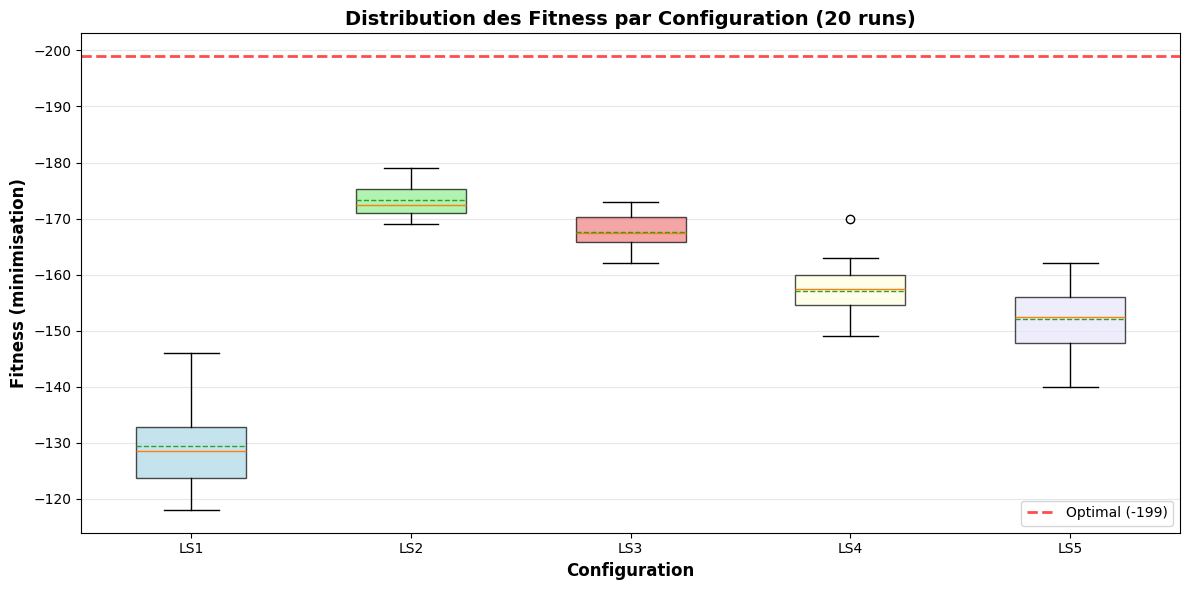


✓ Boxplots générés avec succès


In [25]:
# Graphique 1: Boxplots
fig, ax = plt.subplots(figsize=(12, 6))

# Préparation des données pour boxplot
data_for_boxplot = [results[c]['fitness_values'] for c in configurations.keys()]
labels = list(configurations.keys())

# Création des boxplots
bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True,
                showmeans=True, meanline=True)

# Coloration des boîtes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lavender']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Configuration du graphique
ax.set_ylabel('Fitness (minimisation)', fontsize=12, fontweight='bold')
ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax.set_title('Distribution des Fitness par Configuration (20 runs)', 
             fontsize=14, fontweight='bold')
ax.axhline(y=OPTIMAL_VALUE, color='r', linestyle='--', linewidth=2, 
           label=f'Optimal ({OPTIMAL_VALUE})', alpha=0.7)
ax.grid(True, alpha=0.3, axis='y')
ax.legend(loc='lower right', fontsize=10)

# Inverser l'axe Y pour que l'optimal soit en haut
ax.invert_yaxis()

plt.tight_layout()
#plt.savefig('floatpairs_ls_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Boxplots générés avec succès")

### 8.2 Graphiques Complémentaires (Moyenne, Distance, Temps)

/var/folders/rh/xt3snpjn7ng64htp00_8m9nw0000gn/T/ipykernel_19965/2022224857.py:80: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/salimtitouche/FloatPairs/jmetalpy_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


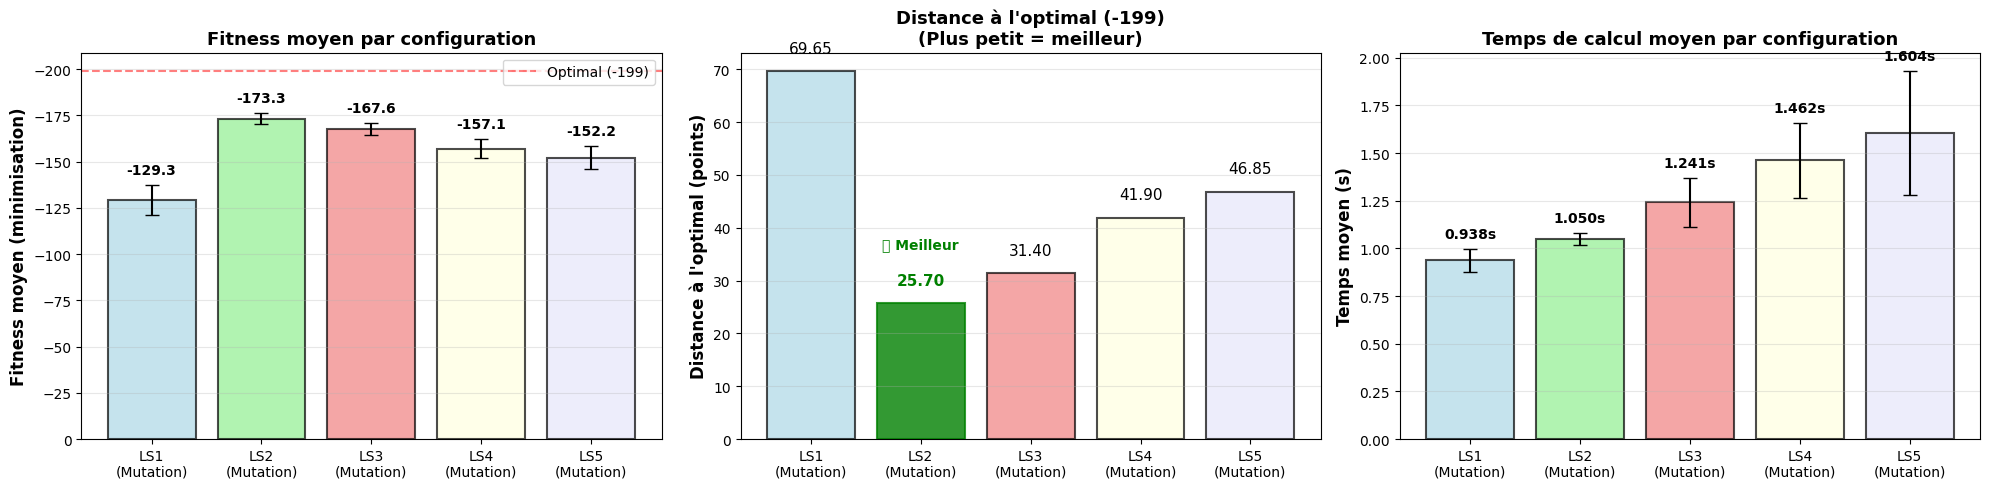


✓ Graphiques complémentaires générés

ANALYSE DES DISTANCES À L'OPTIMAL
LS2 : 25.70 points de l'optimal
LS3 : 31.40 points de l'optimal
LS4 : 41.90 points de l'optimal
LS5 : 46.85 points de l'optimal
LS1 : 69.65 points de l'optimal


In [26]:
# Graphiques complémentaires : Moyenne + Distance + Temps
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

configs = list(configurations.keys())
means = [results[c]['mean'] for c in configs]
stds = [results[c]['std'] for c in configs]
x_pos = np.arange(len(configs))

# Graphique 1 : Barres des moyennes avec écart-type
axes[0].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
           color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[0].set_ylabel('Fitness moyen (minimisation)', fontsize=12, fontweight='bold')
axes[0].set_title('Fitness moyen par configuration', fontsize=13, fontweight='bold')

# Inverser l'axe Y
axes[0].invert_yaxis()

# Ligne de référence
axes[0].axhline(y=OPTIMAL_VALUE, color='r', linestyle='--', alpha=0.5, 
                label=f'Optimal ({OPTIMAL_VALUE})')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].legend(loc='upper right')

# Ajout des valeurs sur les barres (dynamique)
text_offset = abs(OPTIMAL_VALUE) * 0.03  # 3% de la valeur optimale
for i, (m, s) in enumerate(zip(means, stds)):
    axes[0].text(i, m - s - text_offset, f'{m:.1f}', ha='center', fontsize=10, fontweight='bold')

# Graphique 2 : Distance à l'optimal
distances = [abs(OPTIMAL_VALUE - results[c]['mean']) for c in configs]
max_distance = max(distances) if distances else 1  # Éviter division par zéro

bars = axes[1].bar(x_pos, distances, alpha=0.7, color=colors,
                   edgecolor='black', linewidth=1.5)

# Mettre en vert la meilleure (distance la plus petite)
best_idx = distances.index(min(distances))
bars[best_idx].set_color('green')
bars[best_idx].set_alpha(0.8)

axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[1].set_ylabel('Distance à l\'optimal (points)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Distance à l\'optimal ({OPTIMAL_VALUE})\n(Plus petit = meilleur)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres (dynamique)
text_offset_dist = max_distance * 0.05  # 5% de la distance max
for i, d in enumerate(distances):
    color = 'green' if i == best_idx else 'black'
    weight = 'bold' if i == best_idx else 'normal'
    axes[1].text(i, d + text_offset_dist, f'{d:.2f}', ha='center', fontsize=11, 
                fontweight=weight, color=color)

# Annotation pour le meilleur (dynamique)
axes[1].text(best_idx, distances[best_idx] + text_offset_dist * 3, '⭐ Meilleur', 
            ha='center', fontsize=10, color='green', fontweight='bold')

# Graphique 3 : Temps de calcul moyen
times = [results[c]['time_mean'] for c in configs]
time_stds = [results[c]['time_std'] for c in configs]
max_time = max([t + ts for t, ts in zip(times, time_stds)]) if times else 1

axes[2].bar(x_pos, times, yerr=time_stds, capsize=5, alpha=0.7,
           color=colors, edgecolor='black', linewidth=1.5)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'{c}\n({configurations[c]["nom"].split()[0]})' for c in configs])
axes[2].set_ylabel('Temps moyen (s)', fontsize=12, fontweight='bold')
axes[2].set_title('Temps de calcul moyen par configuration', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres (dynamique)
text_offset_time = max_time * 0.03  # 3% du temps max
for i, (t, ts) in enumerate(zip(times, time_stds)):
    axes[2].text(i, t + ts + text_offset_time, f'{t:.3f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
#plt.savefig('floatpairs_ls_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Graphiques complémentaires générés")

print("\n" + "="*60)
print("ANALYSE DES DISTANCES À L'OPTIMAL")
print("="*60)

# Afficher les distances triées
distances_with_names = [(configs[i], distances[i]) for i in range(len(configs))]
distances_with_names.sort(key=lambda x: x[1])

for i, (name, dist) in enumerate(distances_with_names, 1):
    print(f"{name} : {dist:.2f} points de l'optimal")

### 8.3 Évolution de la Performance selon la Probabilité de Mutation

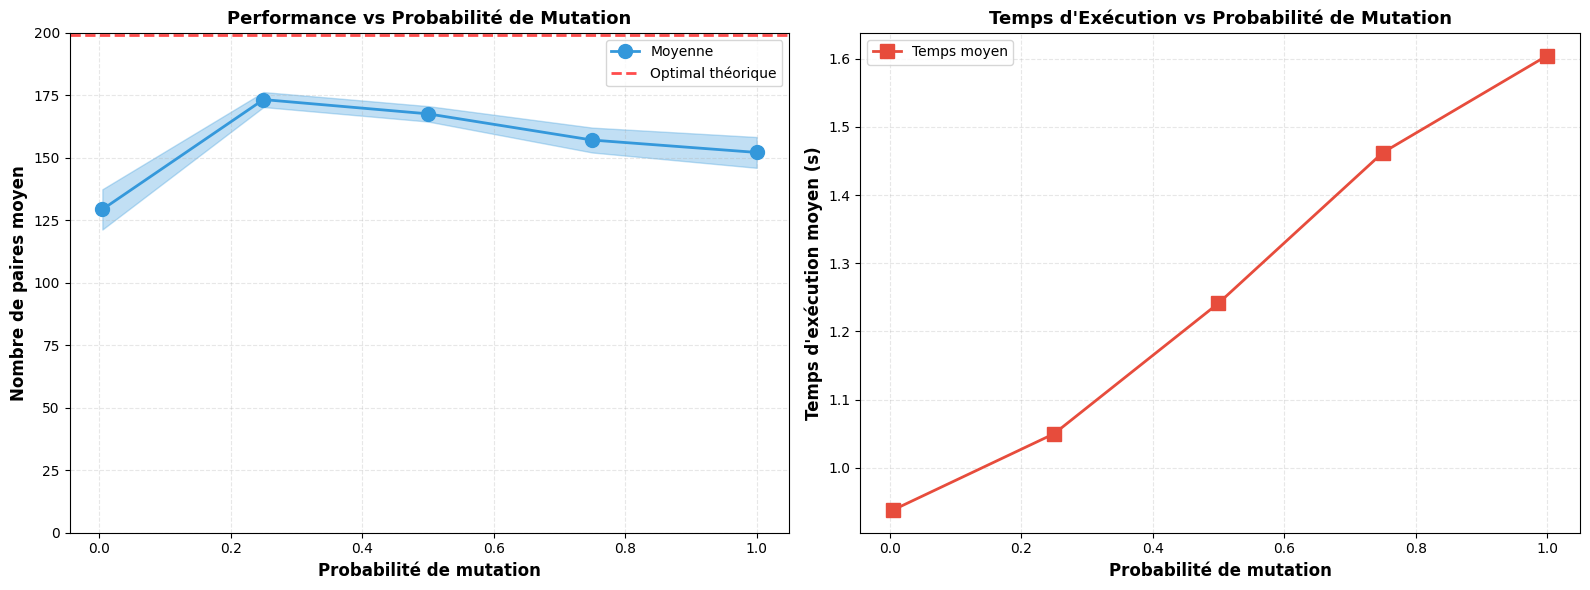

✓ Graphique 3 sauvegardé: 'floatpairs_ls_evolution.png'


In [27]:
# Graphique 3: Évolution selon probabilité de mutation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Probabilités de mutation
mutation_probs = [1.0/N_FLOATS, 0.25, 0.5, 0.75, 1.0]
config_names = list(results.keys())
means_pairs = []
stds_pairs = []
times = []

for config_name in config_names:
    means_pairs.append(-results[config_name]['mean'])
    stds_pairs.append(results[config_name]['std'])
    times.append(results[config_name]['time_mean'])

# Sous-graphique 1: Performance vs Probabilité
ax1.plot(mutation_probs, means_pairs, 'o-', linewidth=2, markersize=10, 
         color='#3498db', label='Moyenne')
ax1.fill_between(mutation_probs, 
                 [m - s for m, s in zip(means_pairs, stds_pairs)],
                 [m + s for m, s in zip(means_pairs, stds_pairs)],
                 alpha=0.3, color='#3498db')
ax1.axhline(y=-OPTIMAL_VALUE, color='red', linestyle='--', linewidth=2, 
            label='Optimal théorique', alpha=0.7)

# Limites dynamiques de l'axe Y
y_max = -OPTIMAL_VALUE + 1
ax1.set_ylim([0, y_max])

ax1.set_xlabel('Probabilité de mutation', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nombre de paires moyen', fontsize=12, fontweight='bold')
ax1.set_title('Performance vs Probabilité de Mutation', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Sous-graphique 2: Temps vs Probabilité
ax2.plot(mutation_probs, times, 's-', linewidth=2, markersize=10, 
         color='#e74c3c', label='Temps moyen')
ax2.set_xlabel('Probabilité de mutation', fontsize=12, fontweight='bold')
ax2.set_ylabel('Temps d\'exécution moyen (s)', fontsize=12, fontweight='bold')
ax2.set_title('Temps d\'Exécution vs Probabilité de Mutation', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
#plt.savefig('floatpairs_ls_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Graphique 3 sauvegardé: 'floatpairs_ls_evolution.png'")

### 8.4 Taux de Succès par Configuration

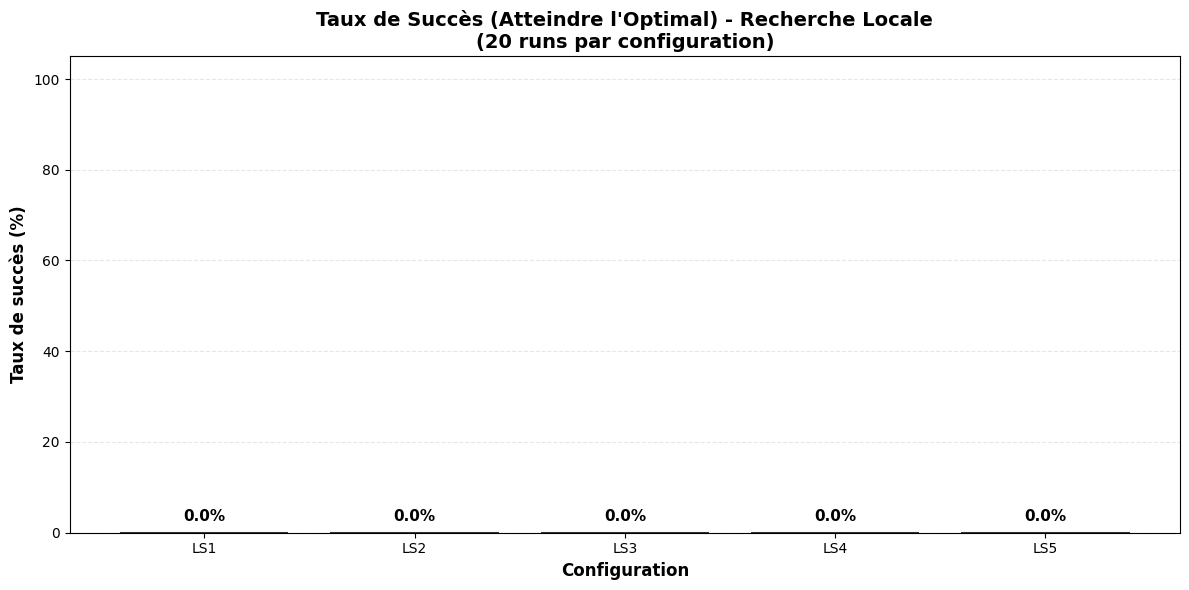

✓ Graphique 4 sauvegardé: 'floatpairs_ls_success_rate.png'


In [28]:
# Graphique 4: Taux de succès
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

config_names = list(results.keys())
success_rates = [results[c]['success_rate'] for c in config_names]

bars = ax.bar(config_names, success_rates,
              color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'],
              alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Taux de succès (%)', fontsize=12, fontweight='bold')
ax.set_title('Taux de Succès (Atteindre l\'Optimal) - Recherche Locale\n(20 runs par configuration)', 
             fontsize=14, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Annotations (dynamiques)
text_offset = 2  # Offset fixe de 2% au-dessus de la barre
for i, (bar, rate) in enumerate(zip(bars, success_rates)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + text_offset,
            f'{rate:.1f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
#plt.savefig('floatpairs_ls_success_rate.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Graphique 4 sauvegardé: 'floatpairs_ls_success_rate.png'")

## 9. Analyse Comparative des Paramètres

In [29]:
print("="*80)
print("ANALYSE COMPARATIVE DES PARAMÈTRES")
print("="*80)

# Identification de la meilleure configuration
best_config = min(results.items(), key=lambda x: x[1]['mean'])
worst_config = max(results.items(), key=lambda x: x[1]['mean'])

print(f"\n🏆 MEILLEURE CONFIGURATION: {best_config[0]}")
print(f"   Description: {configurations[best_config[0]]['nom']}")
print(f"   Moyenne: {-best_config[1]['mean']:.2f} paires")
print(f"   Taux de succès: {best_config[1]['success_rate']:.1f}%")

print(f"\n❌ MOINS BONNE CONFIGURATION: {worst_config[0]}")
print(f"   Description: {configurations[worst_config[0]]['nom']}")
print(f"   Moyenne: {-worst_config[1]['mean']:.2f} paires")
print(f"   Taux de succès: {worst_config[1]['success_rate']:.1f}%")

# Analyse de l'effet de la probabilité de mutation
print("\n" + "="*80)
print("EFFET DE LA PROBABILITÉ DE MUTATION")
print("="*80)

for i, config_name in enumerate(config_names):
    pairs = -results[config_name]['mean']
    prob = mutation_probs[i]
    print(f"\n{config_name} (p={prob:.3f}): {pairs:.2f} paires")
    
    if pairs == -OPTIMAL_VALUE:
        print("   → Atteint l'optimal en moyenne ! ✓")
    else:
        distance = abs(-OPTIMAL_VALUE - pairs)
        print(f"   → Distance à l'optimal: {distance:.2f} paires")

print("\n" + "="*80)
print("OBSERVATIONS GÉNÉRALES")
print("="*80)
print("""
1. L'impact de la probabilité de mutation sur la recherche locale
2. Trade-off entre exploration (forte mutation) et exploitation (faible mutation)
3. La recherche locale converge rapidement mais peut rester dans un optimum local
4. Le temps d'exécution varie selon la probabilité de mutation
""")

print("="*80)

ANALYSE COMPARATIVE DES PARAMÈTRES

🏆 MEILLEURE CONFIGURATION: LS2
   Description: Mutation faible (0.25)
   Moyenne: 173.30 paires
   Taux de succès: 0.0%

❌ MOINS BONNE CONFIGURATION: LS1
   Description: Mutation par défaut (1/n)
   Moyenne: 129.35 paires
   Taux de succès: 0.0%

EFFET DE LA PROBABILITÉ DE MUTATION

LS1 (p=0.005): 129.35 paires
   → Distance à l'optimal: 69.65 paires

LS2 (p=0.250): 173.30 paires
   → Distance à l'optimal: 25.70 paires

LS3 (p=0.500): 167.60 paires
   → Distance à l'optimal: 31.40 paires

LS4 (p=0.750): 157.10 paires
   → Distance à l'optimal: 41.90 paires

LS5 (p=1.000): 152.15 paires
   → Distance à l'optimal: 46.85 paires

OBSERVATIONS GÉNÉRALES

1. L'impact de la probabilité de mutation sur la recherche locale
2. Trade-off entre exploration (forte mutation) et exploitation (faible mutation)
3. La recherche locale converge rapidement mais peut rester dans un optimum local
4. Le temps d'exécution varie selon la probabilité de mutation



## 10. Export des Résultats Détaillés

In [30]:
# Export des données détaillées pour chaque configuration
for config_name, res in results.items():
    detailed_df = pd.DataFrame({
        'Run': range(1, N_RUNS + 1),
        'Fitness': res['fitness_values'],
        'Pairs': [-f for f in res['fitness_values']],
        'Execution_Time': res['execution_times']
    })
    filename = f'floatpairs_ls_{config_name}_detailed.csv'
    detailed_df.to_csv(filename, index=False)
    print(f"✓ Détails de {config_name} exportés dans '{filename}'")

print("\n✓ Tous les fichiers ont été exportés avec succès !")

✓ Détails de LS1 exportés dans 'floatpairs_ls_LS1_detailed.csv'
✓ Détails de LS2 exportés dans 'floatpairs_ls_LS2_detailed.csv'
✓ Détails de LS3 exportés dans 'floatpairs_ls_LS3_detailed.csv'
✓ Détails de LS4 exportés dans 'floatpairs_ls_LS4_detailed.csv'
✓ Détails de LS5 exportés dans 'floatpairs_ls_LS5_detailed.csv'

✓ Tous les fichiers ont été exportés avec succès !
